# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.


In [5]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from utils.data_utils import get_CIFAR10_data

%matplotlib inline
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [7]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_val:  (1000, 3, 32, 32)
y_test:  (1000,)
y_train:  (49000,)
X_test:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
y_val:  (1000,)


In [13]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


In [16]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


# Convolution: Naive forward pass

In [50]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.
    The input consists of N data points, each with C channels, height H and width
    W. We convolve each input with F different filters, where each filter spans
    all C channels and has height HH and width HH.
    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.
    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    ##########################################################################
    # TODO: Implement the convolutional forward pass.                           #
    # Hint: you can use the function np.pad for padding.                        #
    ##########################################################################
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    S = int(conv_param['stride'])
    P = int(conv_param['pad'])

    # Add padding to each image
    x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')
    # Size of the output
    Hh = 1 + (H + 2 * P - HH) / S
    Hw = 1 + (W + 2 * P - WW) / S

    out = np.zeros((N, F, Hh, Hw))

    for n in range(N):  # First, iterate over all the images
        for f in range(F):  # Second, iterate over all the kernels
            for k in range(int(Hh)):
                for l in range(int(Hw)):
                    out[n, f, k, l] = np.sum(
                        x_pad[n, :, k * S:k * S + HH, l * S:l * S + WW] * w[f, :]) + b[f]

    cache = (x, w, b, conv_param)
    return out, cache


In [51]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Aside: Image processing via convolutions

We will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


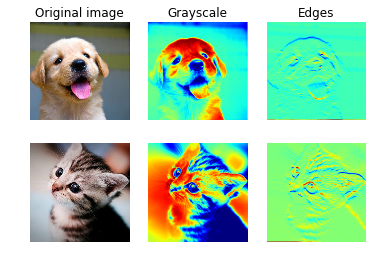

In [19]:
from scipy.misc import imread, imresize

kitten, puppy = imread('utils/kitten.jpg'), imread('utils/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d/2:-d/2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Convolution: Naive backward pass


In [59]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.
    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive
    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    ##########################################################################
    # TODO: Implement the convolutional backward pass.                          #
    ##########################################################################
    x, w, b, conv_param = cache
    P = int(conv_param['pad'])
    x_pad = np.pad(x, ((0,), (0,), (P,), (P,)), 'constant')

    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    N, F, Hh, Hw = dout.shape
    S = conv_param['stride']

    # For dw: Size (C,HH,WW)
    # Brut force love the loops !
    dw = np.zeros((F, C, HH, WW))
    for fprime in range(F):
        for cprime in range(C):
            for i in range(HH):
                for j in range(WW):
                    sub_xpad = x_pad[:, cprime, i:i + Hh * S:S, j:j + Hw * S:S]
                    dw[fprime, cprime, i, j] = np.sum(
                        dout[:, fprime, :, :] * sub_xpad)

    # For db : Size (F,)
    db = np.zeros((F))
    for fprime in range(F):
        db[fprime] = np.sum(dout[:, fprime, :, :])

    dx = np.zeros((N, C, H, W))
    for nprime in range(N):
        for i in range(H):
            for j in range(W):
                for f in range(F):
                    for k in range(Hh):
                        for l in range(Hw):
                            mask1 = np.zeros_like(w[f, :, :, :])
                            mask2 = np.zeros_like(w[f, :, :, :])
                            if (i + P - k * S) < HH and (i + P - k * S) >= 0:
                                mask1[:, i + P - k * S, :] = 1.0
                            if (j + P - l * S) < WW and (j + P - l * S) >= 0:
                                mask2[:, :, j + P - l * S] = 1.0
                            w_masked = np.sum(
                                w[f, :, :, :] * mask1 * mask2, axis=(1, 2))
                            dx[nprime, :, i, j] += dout[nprime, f, k, l] * w_masked

    return dx, dw, db

In [22]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Testing conv_backward_naive function
dx error:  4.69170840329e-09
dw error:  3.41320944965e-10
db error:  7.30463366377e-11


# Max pooling: Naive forward

In [26]:
def max_pool_forward_naive(x, pool_param):
    """
    A naive implementation of the forward pass for a max pooling layer.
    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - pool_param: dictionary with the following keys:
      - 'pool_height': The height of each pooling region
      - 'pool_width': The width of each pooling region
      - 'stride': The distance between adjacent pooling regions
    Returns a tuple of:
    - out: Output data (N,C,H1,W1)
    - cache: (x, pool_param)
    where H1 = (H-Hp)/S+1
    and W1 = (W-Wp)/S+1
    """

    Hp = pool_param['pool_height']
    Wp = pool_param['pool_width']
    S = pool_param['stride']
    N, C, H, W = x.shape
    H1 = (H - Hp) / S + 1
    W1 = (W - Wp) / S + 1

    out = np.zeros((N, C, H1, W1))
    for n in range(N):
        for c in range(C):
            for k in range(int(H1)):
                for l in range(int(W1)):
                    out[n, c, k, l] = np.max(
                        x[n, c, k * S:k * S + Hp, l * S:l * S + Wp])

    cache = (x, pool_param)
    return out, cache

In [27]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Max pooling: Naive backward

In [31]:
def max_pool_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a max pooling layer.
    Inputs:
    - dout: Upstream derivatives
    - cache: A tuple of (x, pool_param) as in the forward pass.
    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    ##########################################################################
    # TODO: Implement the max pooling backward pass                             #
    ##########################################################################
    x, pool_param = cache
    Hp = pool_param['pool_height']
    Wp = pool_param['pool_width']
    S = pool_param['stride']
    N, C, H, W = x.shape
    H1 = (H - Hp) / S + 1
    W1 = (W - Wp) / S + 1
    H1 = int(H1)
    W1 = int(W1)
    dx = np.zeros((N, C, H, W))
    for nprime in range(N):
        for cprime in range(C):
            for k in range(H1):
                for l in range(W1):
                    x_pooling = x[nprime, cprime, k *
                                  S:k * S + Hp, l * S:l * S + Wp]
                    maxi = np.max(x_pooling)
                    x_mask = x_pooling == maxi
                    dx[nprime, cprime, k * S:k * S + Hp, l * S:l *
                        S + Wp] += dout[nprime, cprime, k, l] * x_mask
    return dx

In [32]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Testing max_pool_backward_naive function:
dx error:  3.2756221534e-12


# Convolutional "sandwich" layers

### Combinations of layers

In [55]:
def affine_forward(x, w, b):
  """
  Computes the forward pass for an affine (fully-connected) layer.

  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.

  Inputs:
  - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
  - w: A numpy array of weights, of shape (D, M)
  - b: A numpy array of biases, of shape (M,)
  
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  out = None
  out = x.reshape(x.shape[0], w.shape[0]).dot(w) + b
  cache = (x, w, b)
  return out, cache


def affine_backward(dout, cache):
  """
  Computes the backward pass for an affine layer.

  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)

  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None
  dw = x.reshape(x.shape[0], w.shape[0]).T.dot(dout)
  db = np.sum(dout, axis=0)
  dx = dout.dot(w.T).reshape(x.shape)
  return dx, dw, db

def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).

  Input:
  - x: Inputs, of any shape

  Returns a tuple of:
  - out: Output, of the same shape as x
  - cache: x
  """
  out = None
  out = np.maximum(0, x)
  cache = x
  return out, cache

def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).

  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout

  Returns:
  - dx: Gradient with respect to x
  """
  dx, x = None, cache
  dx = dout
  dx[cache < 0] = 0
  return dx

def affine_relu_forward(x, w, b):
  """
  Convenience layer that perorms an affine transform followed by a ReLU

  Inputs:
  - x: Input to the affine layer
  - w, b: Weights for the affine layer

  Returns a tuple of:
  - out: Output from the ReLU
  - cache: Object to give to the backward pass
  """
  a, fc_cache = affine_forward(x, w, b)
  out, relu_cache = relu_forward(a)
  cache = (fc_cache, relu_cache)
  return out, cache


def affine_relu_backward(dout, cache):
  """
  Backward pass for the affine-relu convenience layer
  """
  fc_cache, relu_cache = cache
  da = relu_backward(dout, relu_cache)
  dx, dw, db = affine_backward(da, fc_cache)
  return dx, dw, db


def conv_relu_forward(x, w, b, conv_param):
    """
    A convenience layer that performs a convolution followed by a ReLU.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, conv_cache = conv_forward_naive(x, w, b, conv_param)
    out, relu_cache = relu_forward(a)

    cache = (conv_cache, relu_cache)
    return out, cache


def conv_relu_backward(dout, cache):
    """
    Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = conv_backward_naive(da, conv_cache)
    return dx, dw, db


def conv_relu_pool_forward(x, w, b, conv_param, pool_param):
    """
    Convenience layer that performs a convolution, a ReLU, and a pool.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer
    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = conv_forward_naive(x, w, b, conv_param)
    s, relu_cache = relu_forward(a)
    out, pool_cache = max_pool_forward_naive(s, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache


def conv_relu_pool_backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = max_pool_backward_naive(dout, pool_cache)
    da = relu_backward(ds, relu_cache)
    dx, dw, db = conv_backward_naive(da, conv_cache)
    return dx, dw, db

def getsoftmaxloss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx


In [41]:
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Testing conv_relu_pool
dx error:  2.28446485389e-08
dw error:  1.70270096513e-09
db error:  1.90810552086e-10


In [43]:
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Testing conv_relu:
dx error:  3.16896319871e-07
dw error:  2.68558004059e-10
db error:  4.05019138643e-11


# Three-layer ConvNet

In [57]:
class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:
    conv - relu - 2x2 max pool - affine - relu - affine - softmax
    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
                 hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32, use_batchnorm=False):
        """
        Initialize a new network.
        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Size of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.use_batchnorm = use_batchnorm
        self.params = {}
        self.reg = reg
        self.dtype = dtype
        self.bn_params = {}

        #######################################################################
        # Initializing weights and biases for the three-layer convolutional    #
        # network. Weights should be initialized from a Gaussian with standard     #
        # deviation equal to weight_scale; biases should be initialized to zero.   #
        # All weights and biases should be stored in the dictionary self.params.   #
        # Store weights and biases for the convolutional layer using the keys 'W1' #
        # and 'b1'; use keys 'W2' and 'b2' for the weights and biases of the       #
        # hidden affine layer, and keys 'W3' and 'b3' for the weights and biases   #
        # of the output affine layer.                                              #
        #######################################################################

        # Size of the input
        C, H, W = input_dim

        # Conv layer
        # The parameters of the conv is of size (F,C,HH,WW) with
        # F give the nb of filters, C,HH,WW characterize the size of
        # each filter
        # Input size : (N,C,H,W)
        # Output size : (N,F,Hc,Wc)
        F = num_filters
        filter_height = filter_size
        filter_width = filter_size
        stride_conv = 1  # stride
        P = (filter_size - 1) / 2  # padd
        Hc = (H + 2 * P - filter_height) / stride_conv + 1
        Wc = (W + 2 * P - filter_width) / stride_conv + 1

        W1 = weight_scale * np.random.randn(F, C, filter_height, filter_width)
        b1 = np.zeros(F)

        # Pool layer : 2*2
        # The pool layer has no parameters but is important in the
        # count of dimension.
        # Input : (N,F,Hc,Wc)
        # Ouput : (N,F,Hp,Wp)

        width_pool = 2
        height_pool = 2
        stride_pool = 2
        Hp = (Hc - height_pool) / stride_pool + 1
        Wp = (Wc - width_pool) / stride_pool + 1

        # Hidden Affine layer
        # Size of the parameter (F*Hp*Wp,H1)
        # Input: (N,F*Hp*Wp)
        # Output: (N,Hh)

        Hh = hidden_dim
        W2 = weight_scale * np.random.randn(F * Hp * Wp, Hh)
        b2 = np.zeros(Hh)

        # Output affine layer
        # Size of the parameter (Hh,Hc)
        # Input: (N,Hh)
        # Output: (N,Hc)

        Hc = num_classes
        W3 = weight_scale * np.random.randn(Hh, Hc)
        b3 = np.zeros(Hc)

        self.params.update({'W1': W1,
                            'W2': W2,
                            'W3': W3,
                            'b1': b1,
                            'b2': b2,
                            'b3': b3})

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.

        if self.use_batchnorm:
            print('We use batchnorm here')
            bn_param1 = {'mode': 'train',
                         'running_mean': np.zeros(F),
                         'running_var': np.zeros(F)}
            gamma1 = np.ones(F)
            beta1 = np.zeros(F)

            bn_param2 = {'mode': 'train',
                         'running_mean': np.zeros(Hh),
                         'running_var': np.zeros(Hh)}
            gamma2 = np.ones(Hh)
            beta2 = np.zeros(Hh)

            self.bn_params.update({'bn_param1': bn_param1,
                                   'bn_param2': bn_param2})

            self.params.update({'beta1': beta1,
                                'beta2': beta2,
                                'gamma1': gamma1,
                                'gamma2': gamma2})

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.
        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        if self.use_batchnorm:
            for key, bn_param in self.bn_params.items():
                bn_param[mode] = mode

        N = X.shape[0]

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']
        if self.use_batchnorm:
            bn_param1, gamma1, beta1 = self.bn_params[
                'bn_param1'], self.params['gamma1'], self.params['beta1']
            bn_param2, gamma2, beta2 = self.bn_params[
                'bn_param2'], self.params['gamma2'], self.params['beta2']

        # pass conv_param to the forward pass for the convolutional layer
        filter_size = W1.shape[2]
        conv_param = {'stride': 1, 'pad': (filter_size - 1) / 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

        scores = None
        # Forward into the conv layer
        x = X
        w = W1
        b = b1
        if self.use_batchnorm:
            beta = beta1
            gamma = gamma1
            bn_param = bn_param1
            conv_layer, cache_conv_layer = conv_norm_relu_pool_forward(
                x, w, b, conv_param, pool_param, gamma, beta, bn_param)
        else:
            conv_layer, cache_conv_layer = conv_relu_pool_forward(
                x, w, b, conv_param, pool_param)

        N, F, Hp, Wp = conv_layer.shape  # output shape

        # Forward into the hidden layer
        x = conv_layer.reshape((N, F * Hp * Wp))
        w = W2
        b = b2
        if self.use_batchnorm:
            gamma = gamma2
            beta = beta2
            bn_param = bn_param2
            hidden_layer, cache_hidden_layer = affine_norm_relu_forward(
                x, w, b, gamma, beta, bn_param)
        else:
            hidden_layer, cache_hidden_layer = affine_relu_forward(x, w, b)
        N, Hh = hidden_layer.shape

        # Forward into the linear output layer
        x = hidden_layer
        w = W3
        b = b3
        scores, cache_scores = affine_forward(x, w, b)

        if y is None:
            return scores

        loss, grads = 0, {}
        #######################################################################
        # Implementing the backward pass for the three-layer convolutional net, #
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #######################################################################

        data_loss, dscores = getsoftmaxloss(scores, y)
        reg_loss = 0.5 * self.reg * np.sum(W1**2)
        reg_loss += 0.5 * self.reg * np.sum(W2**2)
        reg_loss += 0.5 * self.reg * np.sum(W3**2)
        loss = data_loss + reg_loss

        # Backpropagation
        grads = {}
        # Backprop into output layer
        dx3, dW3, db3 = affine_backward(dscores, cache_scores)
        dW3 += self.reg * W3

        # Backprop into first layer
        if self.use_batchnorm:
            dx2, dW2, db2, dgamma2, dbeta2 = affine_norm_relu_backward(
                dx3, cache_hidden_layer)
        else:
            dx2, dW2, db2 = affine_relu_backward(dx3, cache_hidden_layer)

        dW2 += self.reg * W2

        # Backprop into the conv layer
        dx2 = dx2.reshape(N, F, Hp, Wp)
        if self.use_batchnorm:
            dx, dW1, db1, dgamma1, dbeta1 = conv_norm_relu_pool_backward(
                dx2, cache_conv_layer)
        else:
            dx, dW1, db1 = conv_relu_pool_backward(dx2, cache_conv_layer)

        dW1 += self.reg * W1

        grads.update({'W1': dW1,
                      'b1': db1,
                      'W2': dW2,
                      'b2': db2,
                      'W3': dW3,
                      'b3': db3})

        if self.use_batchnorm:
            grads.update({'beta1': dbeta1,
                          'beta2': dbeta2,
                          'gamma1': dgamma1,
                          'gamma2': dgamma2})

        return loss, grads

In [ ]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

## Gradient check
After the loss looks reasonable, using numeric gradient checking to make sure that your backward pass is correct.

In [ ]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net

In [ ]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

## Visualize Filters

In [1]:
def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in xrange(grid_size):
    x0, x1 = 0, W
    for x in xrange(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid


In [2]:
grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

NameError: name 'model' is not defined

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

## Spatial batch normalization: forward


In [6]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.
    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features
    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    ##########################################################################
    # Implementing the forward pass for spatial batch normalization.         #
    #                                                                           #
    # We can implement spatial batch normalization using the vanilla     #
    # version of batch normalization defined above.                             #
    ##########################################################################

    N, C, H, W = x.shape
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    running_mean = bn_param.get('running_mean', np.zeros(C, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(C, dtype=x.dtype))

    if mode == 'train':
        # Step 1 , calcul the average for each channel
        mu = (1. / (N * H * W) * np.sum(x, axis=(0, 2, 3))).reshape(1, C, 1, 1)
        var = (1. / (N * H * W) * np.sum((x - mu)**2,
                                         axis=(0, 2, 3))).reshape(1, C, 1, 1)
        xhat = (x - mu) / (np.sqrt(eps + var))
        out = gamma.reshape(1, C, 1, 1) * xhat + beta.reshape(1, C, 1, 1)

        running_mean = momentum * running_mean + \
            (1.0 - momentum) * np.squeeze(mu)
        running_var = momentum * running_var + \
            (1.0 - momentum) * np.squeeze(var)

        cache = (mu, var, x, xhat, gamma, beta, bn_param)

        # Store the updated running means back into bn_param
        bn_param['running_mean'] = running_mean
        bn_param['running_var'] = running_var

    elif mode == 'test':
        mu = running_mean.reshape(1, C, 1, 1)
        var = running_var.reshape(1, C, 1, 1)

        xhat = (x - mu) / (np.sqrt(eps + var))
        out = gamma.reshape(1, C, 1, 1) * xhat + beta.reshape(1, C, 1, 1)
        cache = (mu, var, x, xhat, gamma, beta, bn_param)

    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    return out, cache


In [7]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  9.03538988  10.00896073   9.36229225]
  Stds:  [ 3.17613457  3.34650949  4.41617976]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ -1.94289029e-17  -4.55191440e-16   3.74700271e-16]
  Stds:  [ 0.9999995   0.99999955  0.99999974]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.99999851  3.99999821  4.99999872]


In [10]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [ 0.04473363  0.01261154  0.0455559   0.0063879 ]
  stds:  [ 1.0171791   1.00752302  0.9659472   1.0092495 ]


## Spatial batch normalization: backward


In [11]:
def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.
    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass
    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ##########################################################################
    # TODO: Implement the backward pass for spatial batch normalization.        #
    #                                                                           #
    # HINT: You can implement spatieal batch normalization using the vanilla     #
    # version of batch normalization defined above. Your implementation should  #
    # be very short; ours is less than five lines.                              #
    ##########################################################################

    mu, var, x, xhat, gamma, beta, bn_param = cache
    N, C, H, W = x.shape
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)

    gamma = gamma.reshape(1, C, 1, 1)
    beta = beta.reshape(1, C, 1, 1)

    dbeta = np.sum(dout, axis=(0, 2, 3))
    dgamma = np.sum(dout * xhat, axis=(0, 2, 3))

    Nt = N * H * W
    dx = (1. / Nt) * gamma * (var + eps)**(-1. / 2.) * (
        Nt * dout
        - np.sum(dout, axis=(0, 2, 3)).reshape(1, C, 1, 1)
        - (x - mu) * (var + eps)**(-1.0) * np.sum(dout * (x - mu), axis=(0, 2, 3)).reshape(1, C, 1, 1))

    return dx, dgamma, dbeta



In [14]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.51549499407e-06
dgamma error:  1.64986841842e-12
dbeta error:  3.27659584803e-12
